In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [4]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


In [5]:
recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion.csv', 
                                                  min_ingredientes=3, max_ingredientes=5,
                                                  min_gramos=100, max_gramos=200,
                                                  numero_recetas=1)

Generando 1  recetas aleatorias...



100%|██████████| 1/1 [00:00<00:00, 501.47it/s]


array([['107gr de cordero  crudo  elección  recortado a 1/4 "grasa  solo delgada separable  boshanco  doméstico, 140gr de carne de res  cruda  seleccionada  recortada a 0 "grasa  solo esbelta separable  compuesto de cortes minoristas recortados, 115gr de frybread  hecho con manteca (apache), 170gr de carne de res  hervida  cocida  molinetes  importados  nueva zelanda',
        '1210.55', '52.98', '84.34', '73.03', '1.77', '1.96']],
      dtype='<U360')


ITERACIÓN: 1
min gramos: 100  max gramos: 200
Entrenando desde epoch 0
------------------------------------------

Cargado dataset de entrenamiento: datasets/recipes_con_info_nutricional.csv
1090 recetas encontradas.
Calculando vector de características de 1090 recetas...


100%|██████████| 1090/1090 [46:29<00:00,  2.56s/it]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

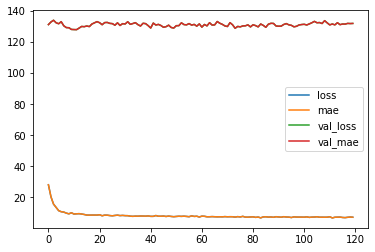

1/1 [==============================] - 0s 181ms/step - loss: 118.3715 - mae: 118.3715
[118.37152099609375, 118.37152099609375]
1/1 [==============================] - 0s 129ms/step
receta 0 kcal_true: 324.0 kcal_pred: 126.19565  precisión: 38.9 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 24.129776  precisión: 31.7 %
receta 0 protein_true: 8.0 protein_pred: 2.1181204  precisión: 26.5 %
receta 0 total_fat_true: 0.0 total_fat_pred: 2.685893  precisión: 0.0 %
receta 0 sugars_true: 0.0 sugars_pred: 17.058598  precisión: 0.0 %
receta 0 fiber_true: 8.0 fiber_pred: 1.483077  precisión: 18.5 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 214.55634  precisión: 49.2 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 35.058258  precisión: 36.5 %
receta 1 protein_true: 8.0 protein_pred: 3.1649246  precisión: 39.6 %
receta 1 total_fat_true: 4.0 total_fat_pred: 6.727511  precisión: 59.5 %
receta 1 sugars_true: 0.0 sugars_

In [9]:
recomendador128.NUM_RECETAS = 100
recomendador128.EMB_SIZE = 128
ITER = 1
INITIAL_EPOCH = 0
EPOCHS = 120

Histories = []
for iteracion in range(ITER):
  MINGRAMOS = 100 
  MAXGRAMOS = 200   
  print('\nITERACIÓN:', iteracion+1)
  print('min gramos:',MINGRAMOS, ' max gramos:', MAXGRAMOS)
  print('Entrenando desde epoch', INITIAL_EPOCH)
  print('------------------------------------------\n')
  modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion.csv',
                                df_training='recipes_con_info_nutricional.csv',
                                df_test='recetas_test.csv', 
                                df_val='recetas_val.csv',
                                learning_rate=1e-5,
                                version=version, 
                                initial_epoch = INITIAL_EPOCH,                             
                                epochs=INITIAL_EPOCH + EPOCHS, 
                                kernels=128,                                             
                                min_ingredientes=3, max_ingredientes=5,
                                min_gramos=MINGRAMOS, max_gramos=MAXGRAMOS,                               
                                save=True, verbose=True)
  INITIAL_EPOCH = history.epoch[-1]

  Histories.append(history)



ITERACIÓN: 1
min gramos: 100  max gramos: 200
Entrenando desde epoch 0
------------------------------------------

Error al cargar archivos NumPy.
datasets/numpy/1000_recetas_random_EMBED-128_DATA_X.npy no existe o está corrupto.
datasets/numpy/1000_recetas_random_EMBED-128_DATA_Y.npy no existe o está corrupto.
Generando 1000  recetas aleatorias...



100%|██████████| 1000/1000 [00:00<00:00, 1300.04it/s]


Calculando vector de características de 1000 recetas...


100%|██████████| 1000/1000 [41:34<00:00,  2.49s/it]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

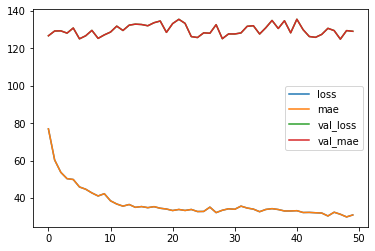

1/1 [==============================] - 0s 191ms/step - loss: 76.9347 - mae: 76.9347
[76.93473052978516, 76.93473052978516]
1/1 [==============================] - 0s 142ms/step
receta 0 kcal_true: 324.0 kcal_pred: 321.553  precisión: 99.2 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 56.852684  precisión: 74.8 %
receta 0 protein_true: 8.0 protein_pred: 11.461061  precisión: 69.8 %
receta 0 total_fat_true: 0.0 total_fat_pred: 6.7898445  precisión: 0.0 %
receta 0 sugars_true: 0.0 sugars_pred: 29.606749  precisión: 0.0 %
receta 0 fiber_true: 8.0 fiber_pred: 3.5342994  precisión: 44.2 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 626.6689  precisión: 69.6 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 100.51851  precisión: 95.5 %
receta 1 protein_true: 8.0 protein_pred: 14.146327  precisión: 56.6 %
receta 1 total_fat_true: 4.0 total_fat_pred: 19.475903  precisión: 20.5 %
receta 1 sugars_true: 0.0 sugars_pred

100%|██████████| 1000/1000 [00:00<00:00, 1261.27it/s]


Calculando vector de características de 1000 recetas...


100%|██████████| 1000/1000 [43:03<00:00,  2.58s/it]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

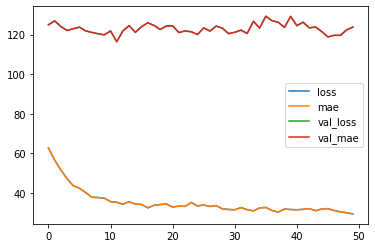

1/1 [==============================] - 0s 183ms/step - loss: 62.6501 - mae: 62.6501
[62.650081634521484, 62.650081634521484]
1/1 [==============================] - 0s 140ms/step
receta 0 kcal_true: 324.0 kcal_pred: 350.53888  precisión: 92.4 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 62.518703  precisión: 82.3 %
receta 0 protein_true: 8.0 protein_pred: 13.123102  precisión: 61.0 %
receta 0 total_fat_true: 0.0 total_fat_pred: 7.7238655  precisión: 0.0 %
receta 0 sugars_true: 0.0 sugars_pred: 29.086437  precisión: 0.0 %
receta 0 fiber_true: 8.0 fiber_pred: 4.3330464  precisión: 54.2 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 544.1449  precisión: 80.1 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 95.05409  precisión: 99.0 %
receta 1 protein_true: 8.0 protein_pred: 13.198582  precisión: 60.6 %
receta 1 total_fat_true: 4.0 total_fat_pred: 14.670778  precisión: 27.3 %
receta 1 sugars_true: 0.0 sugars_p

100%|██████████| 1000/1000 [00:00<00:00, 1097.02it/s]


Calculando vector de características de 1000 recetas...


 32%|███▏      | 317/1000 [14:33<33:45,  2.97s/it]

In [10]:
recomendador128.NUM_RECETAS = 1000
recomendador128.EMB_SIZE = 128
ITER = 3
INITIAL_EPOCH = 0
EPOCHS = 50

#Histories = []
for iteracion in range(ITER):
  MINGRAMOS = 100 
  MAXGRAMOS = 200   
  print('\nITERACIÓN:', iteracion+1)
  print('min gramos:',MINGRAMOS, ' max gramos:', MAXGRAMOS)
  print('Entrenando desde epoch', INITIAL_EPOCH)
  print('------------------------------------------\n')
  modelo128, history2 = recomendador128.EntrenarModelo(df_nutricionales='nutricion.csv',
                                #df_training='recipes_con_info_nutricional.csv',
                                df_test='recetas_test.csv', 
                                df_val='recetas_val.csv',
                                learning_rate=1e-5,
                                version=version, 
                                initial_epoch = INITIAL_EPOCH,                             
                                epochs=INITIAL_EPOCH + EPOCHS, 
                                kernels=128,                                             
                                min_ingredientes=3, max_ingredientes=5,
                                min_gramos=MINGRAMOS, max_gramos=MAXGRAMOS,                               
                                save=True, verbose=True)
  INITIAL_EPOCH = history2.epoch[-1]

  Histories.append(history2)

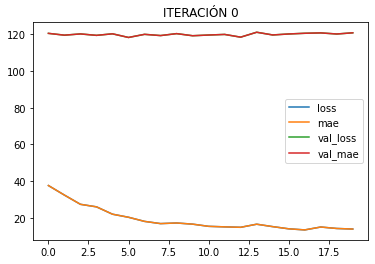

LOSS: 13.986808776855469  -- MAE: 13.986808776855469  -- VAL_LOSS: 120.7373046875  -- VAL_MAE: 120.7373046875
----------------------------------------------------------


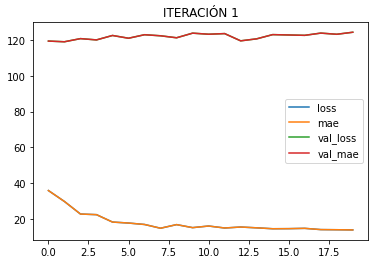

LOSS: 13.757303237915039  -- MAE: 13.757303237915039  -- VAL_LOSS: 124.42042541503906  -- VAL_MAE: 124.42042541503906
----------------------------------------------------------


In [ ]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')